In [0]:
!pip install GPY
!pip install gpyopt
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/47/d1/ba/1a686af7cc042edde2c2f4cb18bd981f7eefdcbfe688590d25
Successfully built japanize-matplotlib


#データ準備

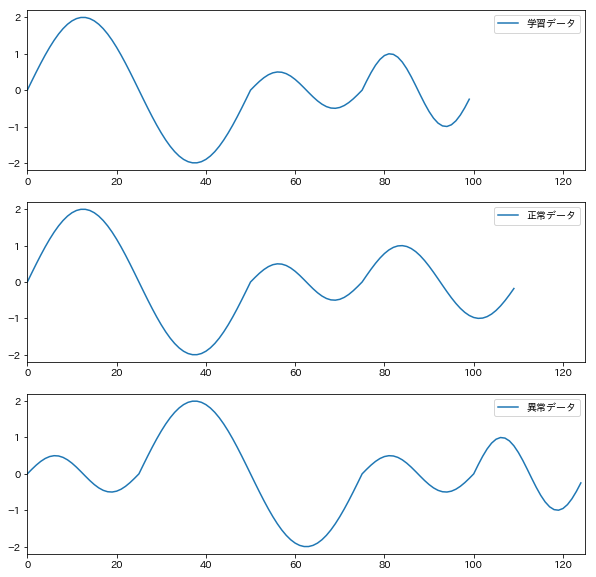

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import cv2

x_train = 2*np.sin(2*np.pi*np.array(np.arange(50))/50)
A = 0.5*np.sin(2*np.pi*np.array(np.arange(25))/25)
B = 1*np.sin(2*np.pi*np.array(np.arange(25))/25)

x_train = np.hstack((x_train,A))
x_train = np.hstack((x_train,B))

x_normal = 2*np.sin(2*np.pi*np.array(np.arange(50))/50)
A = 0.5*np.sin(2*np.pi*np.array(np.arange(25))/25)
B = 1*np.sin(2*np.pi*np.array(np.arange(35))/35)

x_normal = np.hstack((x_normal,A))
x_normal = np.hstack((x_normal,B))

x_anomaly = 0.5*np.sin(2*np.pi*np.array(np.arange(25))/25)
A = 2*np.sin(2*np.pi*np.array(np.arange(50))/50)
B = 0.5*np.sin(2*np.pi*np.array(np.arange(25))/25)
C = 1*np.sin(2*np.pi*np.array(np.arange(25))/25)

x_anomaly = np.hstack((x_anomaly,A))
x_anomaly = np.hstack((x_anomaly,B))
x_anomaly = np.hstack((x_anomaly,C))

plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(x_train, label="学習データ")
plt.xlim(0,125)
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_normal, label="正常データ")
plt.xlim(0,125)
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_anomaly, label="異常データ")
plt.xlim(0,125)
plt.legend()

plt.show()

#見やすいように分割表示

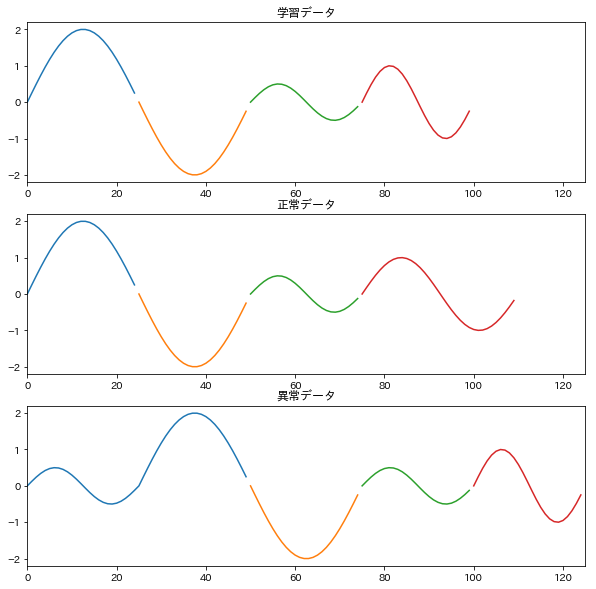

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(range(25),x_train[0:25])
plt.plot(range(25,50),x_train[25:50])
plt.plot(range(50,75),x_train[50:75])
plt.plot(range(75,100),x_train[75:])
plt.xlim(0,125)
plt.title("学習データ")

plt.subplot(3,1,2)
plt.plot(range(25),x_normal[0:25])
plt.plot(range(25,50),x_normal[25:50])
plt.plot(range(50,75),x_normal[50:75])
plt.plot(range(75,110),x_normal[75:])
plt.xlim(0,125)
plt.title("正常データ")

plt.subplot(3,1,3)
plt.plot(range(50),x_anomaly[0:50])
plt.plot(range(50,75),x_anomaly[50:75])
plt.plot(range(75,100),x_anomaly[75:100])
plt.plot(range(100,125),x_anomaly[100:])
plt.xlim(0,125)
plt.title("異常データ")

plt.show()

#ベイズ最適化

In [0]:
import GPy
import GPyOpt

class bayesian_opt:
  def __init__(self, train, test):
      self.exp_num = 15#探索回数
      self.try_ = 1
      self.train = train
      self.ratio = len(test)/len(train)
      self.test = cv2.resize(test,(1,100))
      print("Bayesian Optimization")
     
  def cos_sim(self, v1, v2):
      v2 = cv2.resize(v2, (1,25))
      return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

  def f(self, x):
      score = []
      score.append(self.cos_sim(self.train[0:25] , self.test[0:int(x[:,0])]))
      score.append(self.cos_sim(self.train[25:50] , self.test[int(x[:,0]):int(x[:,1])]))
      score.append(self.cos_sim(self.train[50:75] , self.test[int(x[:,1]):int(x[:,2])]))
      score.append(self.cos_sim(self.train[75:100] , self.test[int(x[:,2]):]))
      score = np.mean(score)
      print(score)
        
      self.try_ += 1
    
      return -score
    
  def main(self):
      bounds = [{'name': 'x1', 'type': 'continuous', 'domain': (15,35)},
                {'name': 'x2', 'type': 'continuous', 'domain': (40,60)},
                {'name': 'x3', 'type': 'continuous', 'domain': (65,85)}]#実験条件の範囲


      #予備実験のデータを持っていない場合はinitial_design_numdataの値を変更
      myBopt = GPyOpt.methods.BayesianOptimization(f = self.f,
                                                   domain = bounds,
                                                   initial_design_numdata = 5)
      myBopt.run_optimization(max_iter=self.exp_num)
      
      #最適なパラメータ
      result = self.ratio*myBopt.x_opt
      result = np.array(result, dtype="int")
      print("Best x is ",result)
      return result
      
opt1 = bayesian_opt(x_train, x_normal)
result1 = opt1.main()

opt2 = bayesian_opt(x_train, x_anomaly)
result2 = opt2.main()

Bayesian Optimization
0.8790826057408574
0.3837476563873936
0.8989547189281502
0.44248234627664573
0.8363295736274718
0.9561398525194612
0.7044651849757227
0.9630973882420629
0.9956155275778559
0.6672921498998403
0.8767689357464109
0.9911909533300216
0.9321729628699673
0.9986278194406981
0.2750639202911857
0.9867798682872104
0.6305679122684256
0.8049620173880041
0.001925889321797318
0.9925459825256407
Best x is  [26 51 75]
Bayesian Optimization
-0.29220143697398177
0.13949778764424553
-0.12546105295409934
-0.27352752370846606
-0.09996975245371953
0.32335871157808993
0.6908864867822284
0.5788795146990302
0.7777410594208274
0.6578655829533352
0.7211888013004581
0.3834629249471345
0.010980114634046814
0.3203888933942482
0.2063967043859425
0.7983707802644882
-0.023425108048367255
0.44223309550743584
0.3858916171906158
-0.06913611151081667
Best x is  [43 75 99]


#最適化による分割を表示

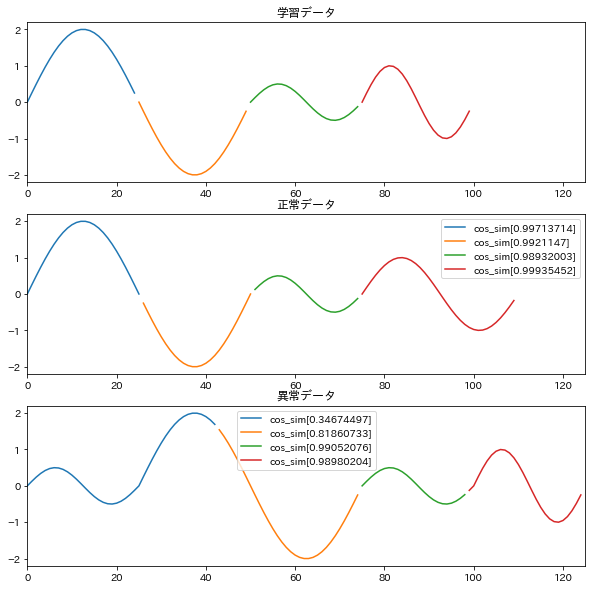

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(range(25),x_train[0:25])
plt.plot(range(25,50),x_train[25:50])
plt.plot(range(50,75),x_train[50:75])
plt.plot(range(75,100),x_train[75:])
plt.xlim(0,125)
plt.title("学習データ")

plt.subplot(3,1,2)
plt.plot(range(result1[0]),x_normal[0:result1[0]],
         label="cos_sim{0}".format(opt1.cos_sim(x_train[0:25],x_normal[0:result1[0]])))
plt.plot(range(result1[0],result1[1]),x_normal[result1[0]:result1[1]],
         label="cos_sim{0}".format(opt1.cos_sim(x_train[25:50],x_normal[result1[0]:result1[1]])))
plt.plot(range(result1[1],result1[2]),x_normal[result1[1]:result1[2]],
         label="cos_sim{0}".format(opt1.cos_sim(x_train[50:75],x_normal[result1[1]:result1[2]])))
plt.plot(range(result1[2],len(x_normal)),x_normal[result1[2]:],
         label="cos_sim{0}".format(opt1.cos_sim(x_train[75:],x_normal[result1[2]:])))
plt.legend()
plt.xlim(0,125)
plt.title("正常データ")

plt.subplot(3,1,3)
plt.plot(range(result2[0]),x_anomaly[0:result2[0]],
         label="cos_sim{0}".format(opt2.cos_sim(x_train[0:25],x_anomaly[0:result2[0]])))
plt.plot(range(result2[0],result2[1]),x_anomaly[result2[0]:result2[1]],
         label="cos_sim{0}".format(opt2.cos_sim(x_train[25:50],x_anomaly[result2[0]:result2[1]])))
plt.plot(range(result2[1],result2[2]),x_anomaly[result2[1]:result2[2]],
         label="cos_sim{0}".format(opt2.cos_sim(x_train[50:75],x_anomaly[result2[1]:result2[2]])))
plt.plot(range(result2[2],len(x_anomaly)),x_anomaly[result2[2]:],
         label="cos_sim{0}".format(opt2.cos_sim(x_train[75:],x_anomaly[result2[2]:])))
plt.legend()
plt.xlim(0,125)
plt.title("異常データ")

plt.show()